# AI Fairness 360

AI Fairness 360 (AIF360) es una biblioteca de código abierto desarrollada por IBM para ayudar a identificar y mitigar el sesgo en modelos de aprendizaje automático y en los conjuntos de datos utilizados para entrenarlos. 

AIF360 proporciona herramientas y métricas que permiten evaluar, comprender y corregir estos sesgos en las diferentes etapas por las que pasan estos datos (pre-process, in-process, post-process)

#### Demostración de mitigación de sesgo usando algoritmos de rebalanceo en el preprocesamiento 


### 1. Importar librerías

In [1]:
%matplotlib inline
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt



pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
from collections import OrderedDict
from aif360.metrics import ClassificationMetric
def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

### 2. Cargar datos y definir métricas

Los datos usados provienen de https://archive.ics.uci.edu/dataset/2/adult. Este dataset contiene al rededor de 34000 registros referentes a datos demográficos tomados en un censo en 1994. Basado en esta información, se pretende predecir si la persona tiene ingresos por más de $50K/año

In [3]:
protected_attribute_used = 1 # 1 for SEX attribute, 2 for RACE attribute
 
if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}] # Hombres
        unprivileged_groups = [{'sex': 0}] # Mujeres
        dataset_orig = load_preproc_data_adult(['sex'])
else:
    privileged_groups = [{'race': 1}]
    unprivileged_groups = [{'race': 0}]
    dataset_orig = load_preproc_data_adult(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

### 3. Separar datos originales en datos de entrenamiento y datos de prueba

In [4]:
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [5]:
display(Markdown("#### Dataset de entrenamiento"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Atributos protegidos"))
print(dataset_orig_train.protected_attribute_names)

#### Dataset de entrenamiento

(34189, 18)


#### Atributos protegidos

['sex']


### 4. Medir la equidad en los datos originales

**BinaryLabelDatasetMetric** es una clase que permite evaluar métricas de equidad en conjuntos de datos binarios.

**Diferencia de paridad estadística** es una métrica que mide la diferencia en las tasas de resultados favorables (como la aprobación de un préstamo) entre dos grupos, como hombres y mujeres. Se calcula restando la proporción de resultados favorables del grupo no privilegiado de la proporción del grupo privilegiado. Si la diferencia es cercana a cero, indica que ambos grupos tienen tasas similares de resultados favorables, sugiriendo equidad en el tratamiento. Por el contrario, una gran diferencia sugiere que hay un sesgo en favor de uno de los grupos.

In [6]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Dataset original de entrenamiento "))
print("La diferencia de paridad estadística entre hombres y mujeres es de = %f" % metric_orig_train.mean_difference())

#### Dataset original de entrenamiento 

La diferencia de paridad estadística entre hombres y mujeres es de = -0.190244


### 5. Rebalancear el dataset original para eliminar el sesgo

In [7]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

### 6. Medir la equidad en los datos rebalanceados

In [8]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Dataset Rebalanceado"))
print("La diferencia de paridad estadística entre hombres y mujeres es de = %f" % metric_transf_train.mean_difference())

#### Dataset Rebalanceado

La diferencia de paridad estadística entre hombres y mujeres es de = 0.000000


### 7. Clasificación datos originales

#### 7.1 Entrenar el clasificador

In [9]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### 7.2 Clasificar datos de prueba y validación con el modelo entrenado

In [10]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

#### 7.3 Encontrar el punto optimo de clasificación del conjunto de datos de validación

In [11]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7463
Optimal classification threshold (no reweighing) = 0.2872


#### 7.4 Calcular métricas de sesgo sobre las predicciones realizadas por el modelo

In [12]:
display(Markdown("#### Métricas de las predicciones realizadas sobre la data original de prueba"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Punto óptimo de clasificación = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Métricas de las predicciones realizadas sobre la data original de prueba

Punto óptimo de clasificación = 0.2872


 19%|█▉        | 19/100 [00:00<00:00, 168.11it/s]

Balanced accuracy = 0.7437
Statistical parity difference = -0.3580
Disparate impact = 0.2794
Average odds difference = -0.3181
Equal opportunity difference = -0.3769
Theil index = 0.1129


 72%|███████▏  | 72/100 [00:00<00:00, 157.92it/s]c:\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 157.34it/s]


#### 7.5 Graficar resultados 

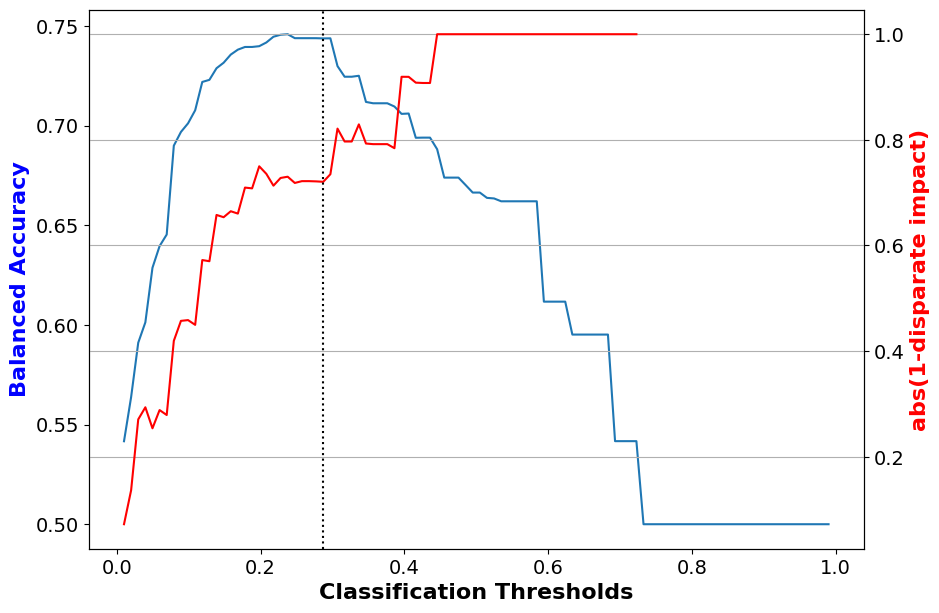

In [13]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` debe ser cercano a cero para que las predicciones sean justas.

Sin embargo, al hacerlo sobre la data original, en su punto optimo de clasificación, este valor es un poco alto, lo que implica injusticia.

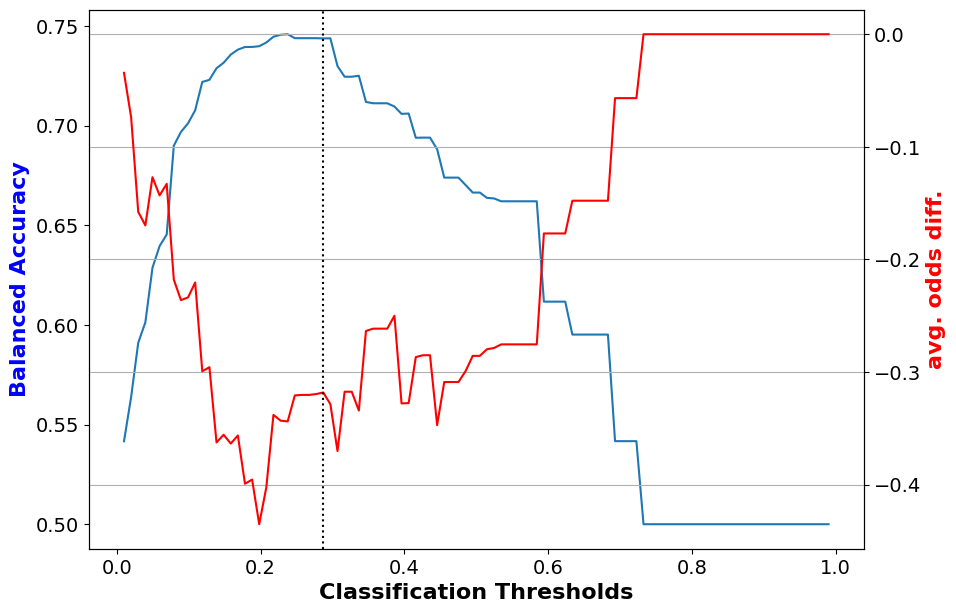

In [14]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` debe ser cercano a cero para que el clasificador se considere justo.

Sin embargo, al hacerlo sobre la data original, en su punto optimo de clasificación, este valor es un poco alto, lo que implica injusticia.

### 8. Clasificación datos transformados

#### 8.1  Entrenar el clasificador

In [15]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

#### 8.2 Clasificar datos de prueba y validación con el modelo entrenado

In [16]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

#### 8.3 Calcular métricas de sesgo sobre las predicciones realizadas por el modelo

In [17]:
display(Markdown("#### Métricas de las predicciones realizadas sobre la data original de prueba"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Punto óptimo de clasificación = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Métricas de las predicciones realizadas sobre la data original de prueba

Punto óptimo de clasificación = 0.2872


 17%|█▋        | 17/100 [00:00<00:00, 156.40it/s]

Balanced accuracy = 0.7134
Statistical parity difference = -0.0705
Disparate impact = 0.7785
Average odds difference = 0.0188
Equal opportunity difference = 0.0293
Theil index = 0.1401


 54%|█████▍    | 54/100 [00:00<00:00, 168.77it/s]c:\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
c:\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 174.72it/s]


#### 8.4 Graficar resultados

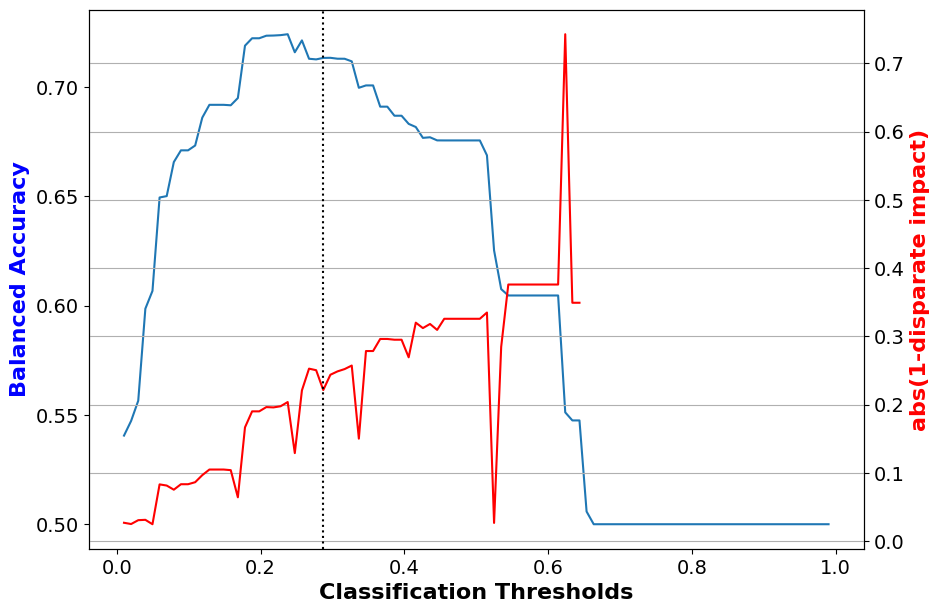

In [18]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

En este caso, la metrica ```abs(1-disparate impact)``` es cercana a 0, implicando justicia en las predicciones realizadas sobre la data rebalanceada

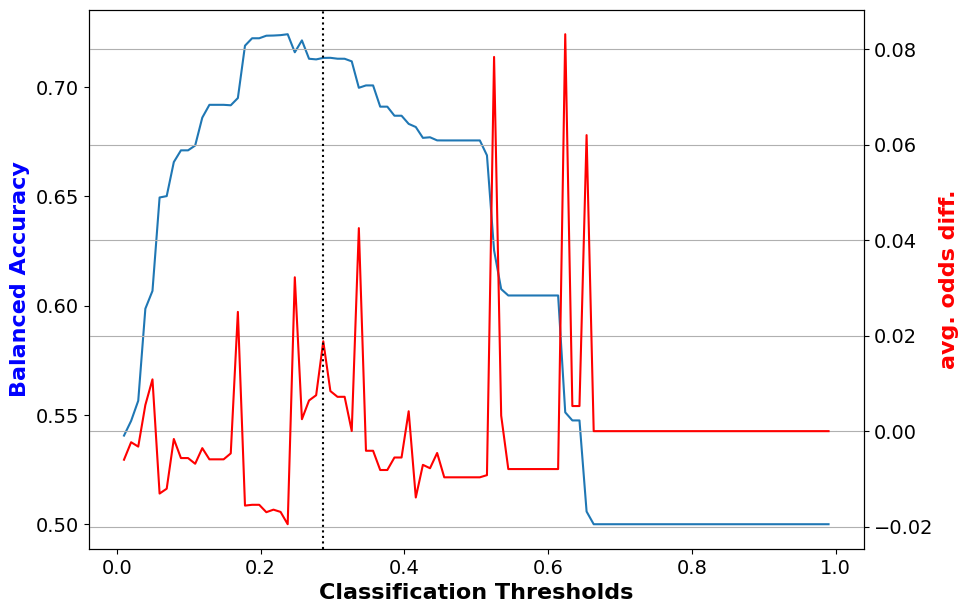

In [19]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

En este caso, la metrica ```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` es cercana a 0, implicando justicia en las predicciones realizadas sobre la data rebalanceada

### 9. Comparación de resultados

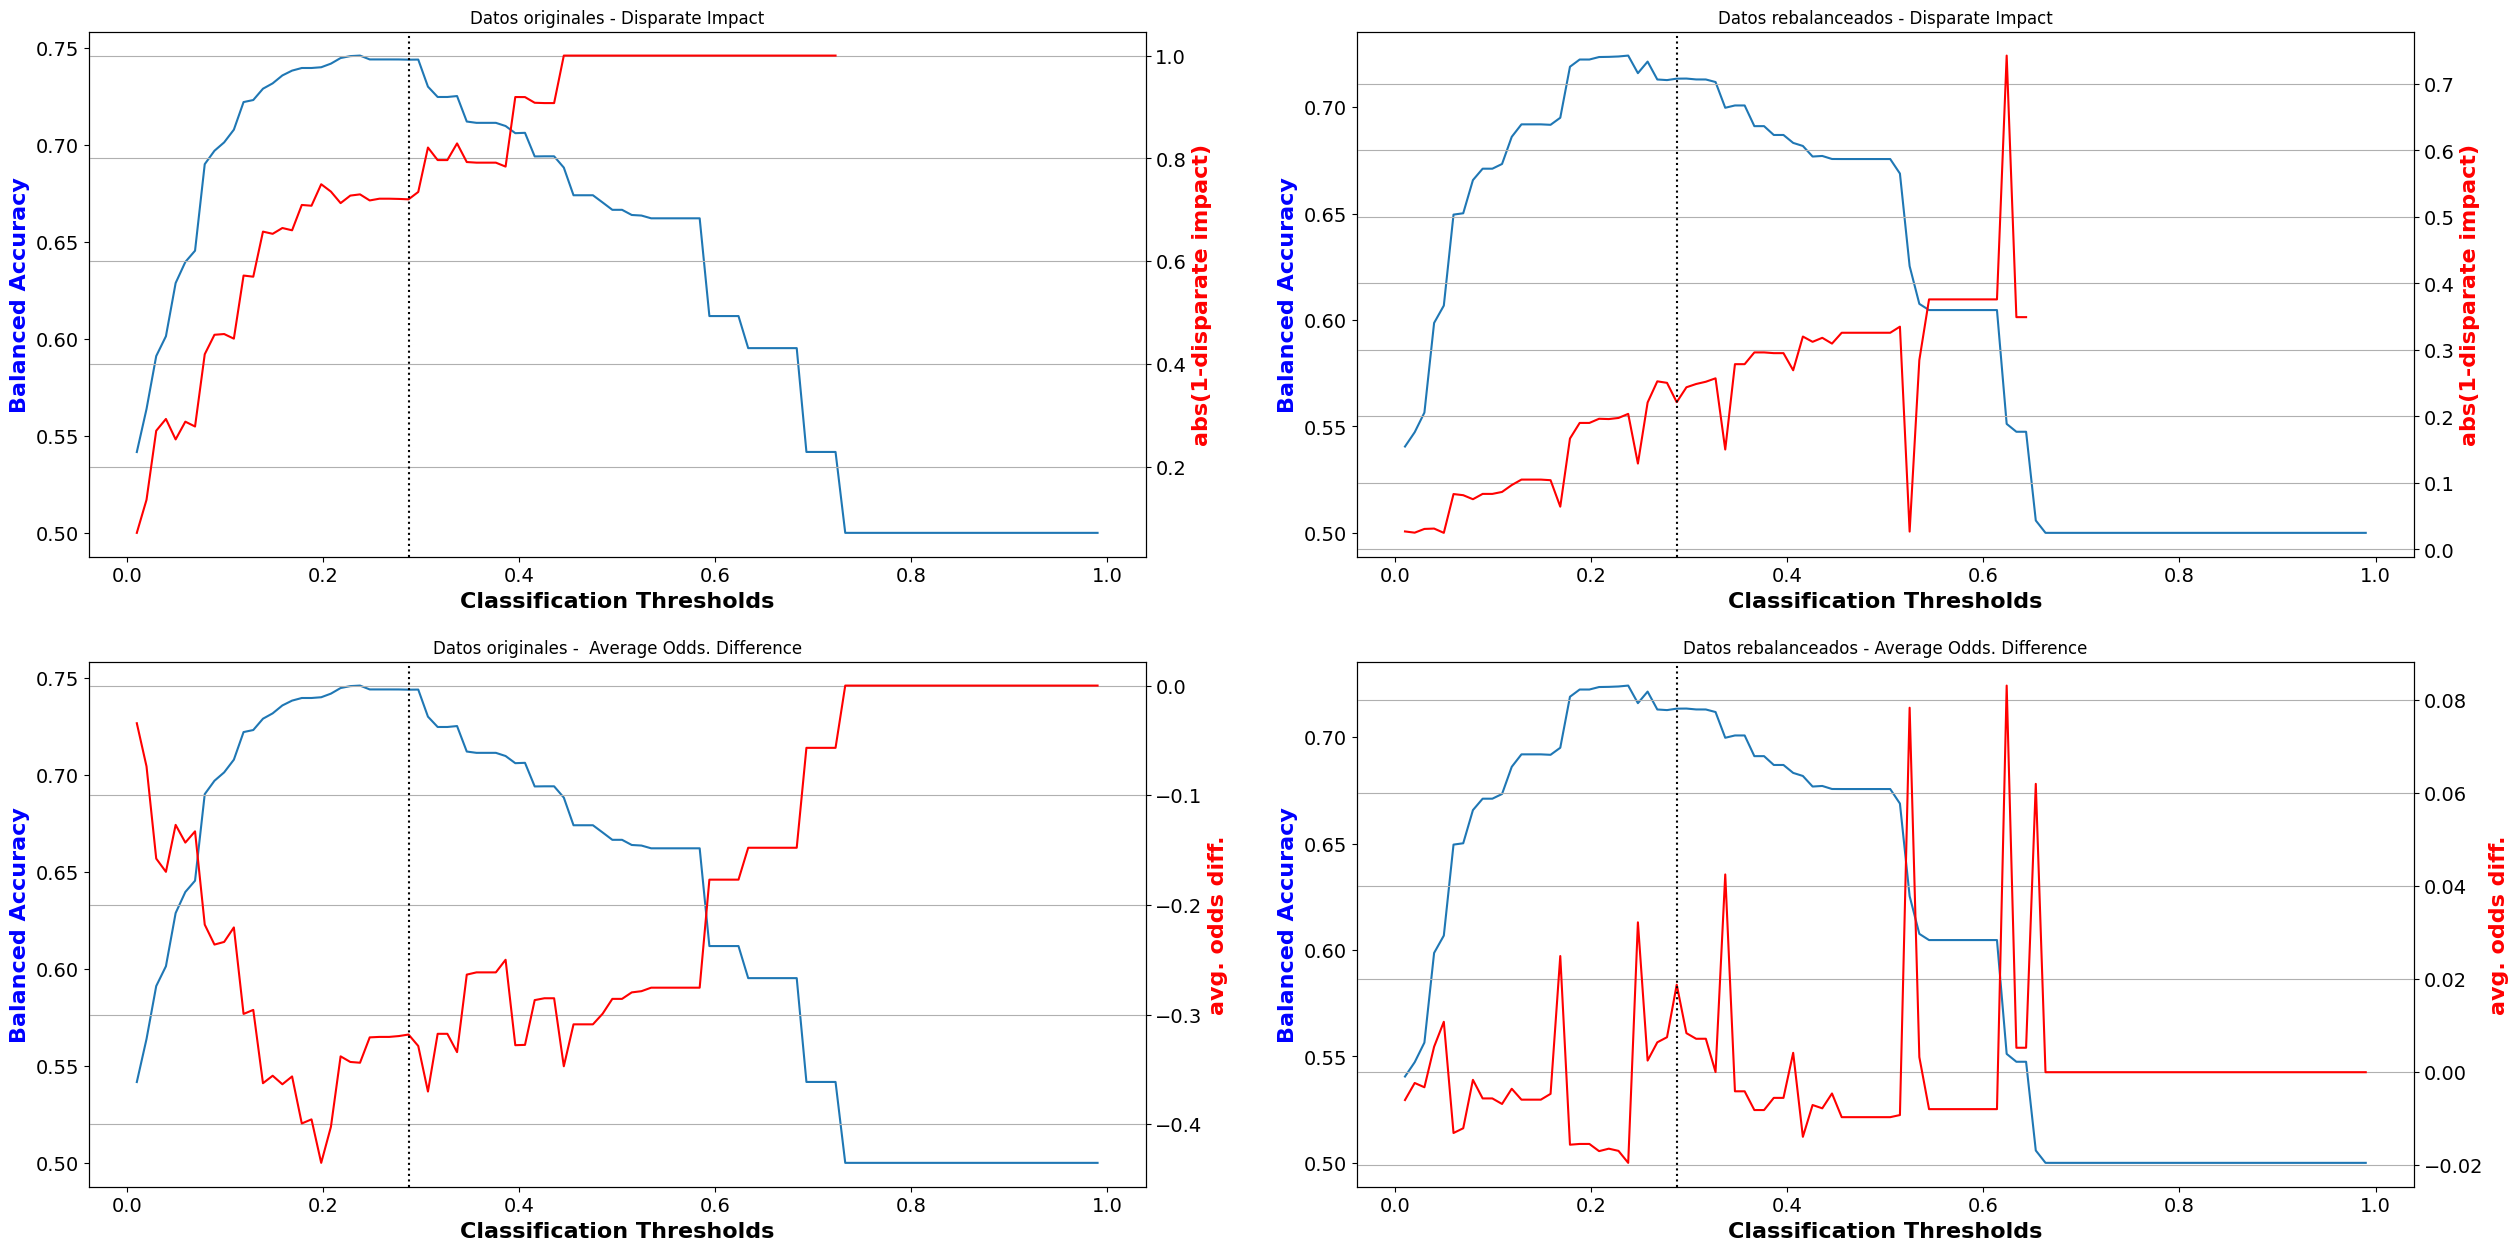

In [20]:
fig, ax = plt.subplots(figsize=(30,15), nrows=2, ncols=2)

ax1 = ax[0][0]

ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_title('Datos originales - Disparate Impact')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

ax1 = ax[0][1]

ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_title('Datos rebalanceados - Disparate Impact')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

ax1 = ax[1][0]

ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_title('Datos originales -  Average Odds. Difference')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


ax1 = ax[1][1]

ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_title('Datos rebalanceados - Average Odds. Difference')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### 10. Resumen de los resultados


### Punto óptimo de clasificación

| Dataset |Classification threshold|
|-|-|
|Adult|0.2872|

### Métrica de justicia: Disparate impact  -  Métrica de exactitud: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|-|
|Adult (Test)|0.7437|0.7134|0.2794|0.7785|

### Métrica de justicia: Average odds difference  -  Métrica de exactitud: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|-|
|Adult (Test)|0.7437|0.7134|-0.3181|0.0188|

### Referencias
-   [AI Fairness 360](https://aif360.res.ibm.com/)
-   [Conjunto de datos "Adult" del UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult)
-   [Ejemplo de rebalanceo de datos - AI Fairness 360](https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_reweighing_preproc.ipynb)